<a href="https://www.kaggle.com/code/mohamedmustafashaban/cib-analysis-prediction-g-rf?scriptVersionId=219634379" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [160]:
# Install lifelines library if not already installed
#lifelines: A library used for survival analysis.
#plotly and seaborn: Libraries for creating interactive and static visualizations.
#!pip install lifelines
#!pip install plotly seaborn
#!pip install pandas numpy matplotlib seaborn xgboost lightgbm scikit-learn imbalanced-learn shap lime

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE
import shap
from lime.lime_tabular import LimeTabularExplainer
from warnings import filterwarnings
filterwarnings('ignore')

In [162]:
train_data = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
test_data = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')

In [163]:
train_data.isnull().sum()

ID                            0
dri_score                   154
psych_disturb              2062
cyto_score                 8068
diabetes                   2119
hla_match_c_high           4620
hla_high_res_8             5829
tbi_status                    0
arrhythmia                 2202
hla_low_res_6              3270
graft_type                    0
vent_hist                   259
renal_issue                1915
pulm_severe                2135
prim_disease_hct              0
hla_high_res_6             5284
cmv_status                  634
hla_high_res_10            7163
hla_match_dqb1_high        5199
tce_imm_match             11133
hla_nmdp_6                 4197
hla_match_c_low            2800
rituximab                  2148
hla_match_drb1_low         2643
hla_match_dqb1_low         4194
prod_type                     0
cyto_score_detail         11923
conditioning_intensity     4789
ethnicity                   587
year_hct                      0
obesity                    1760
mrd_hct 

In [164]:
imputer = SimpleImputer(strategy='median')
train_data_imputed = pd.DataFrame(imputer.fit_transform(train_data.select_dtypes(include=['float64', 'int64'])))
train_data_imputed.columns = train_data.select_dtypes(include=['float64', 'int64']).columns

In [165]:
# Check for missing values after handling
print("\nMissing Values After Handling:")
print(train_data.isnull().sum())


Missing Values After Handling:
ID                            0
dri_score                   154
psych_disturb              2062
cyto_score                 8068
diabetes                   2119
hla_match_c_high           4620
hla_high_res_8             5829
tbi_status                    0
arrhythmia                 2202
hla_low_res_6              3270
graft_type                    0
vent_hist                   259
renal_issue                1915
pulm_severe                2135
prim_disease_hct              0
hla_high_res_6             5284
cmv_status                  634
hla_high_res_10            7163
hla_match_dqb1_high        5199
tce_imm_match             11133
hla_nmdp_6                 4197
hla_match_c_low            2800
rituximab                  2148
hla_match_drb1_low         2643
hla_match_dqb1_low         4194
prod_type                     0
cyto_score_detail         11923
conditioning_intensity     4789
ethnicity                   587
year_hct                      0
obesity 

In [166]:
train_data_processed = pd.concat([train_data_imputed, train_data.select_dtypes(include=['object'])], axis=1)

In [167]:
train_data_processed = pd.get_dummies(train_data_processed)

# 1. Distribution of Numerical Variables

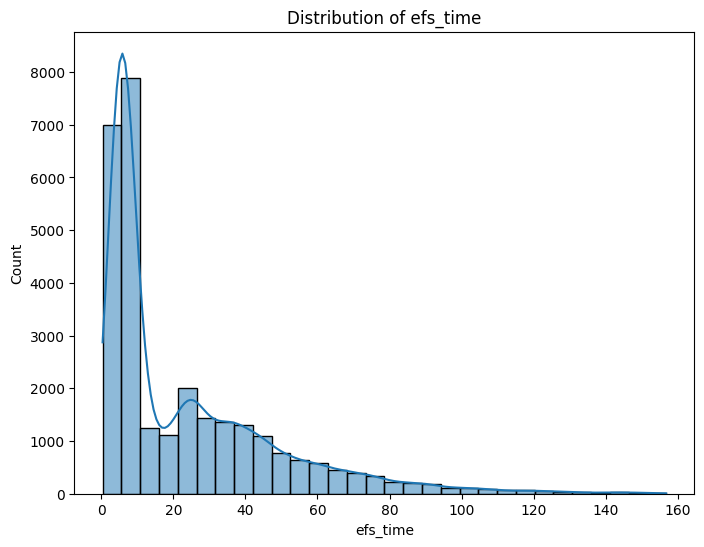

In [168]:
# 1.1 Histogram for 'efs_time'
plt.figure(figsize=(8, 6))
sns.histplot(train_data['efs_time'], bins=30, kde=True)
plt.title("Distribution of efs_time")
plt.show()


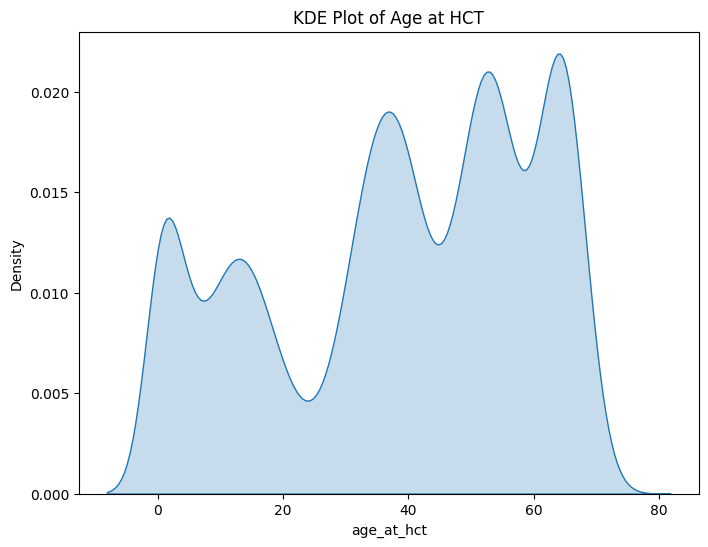

In [169]:
# 1.2 KDE Plot for 'age_at_hct'
plt.figure(figsize=(8, 6))
sns.kdeplot(train_data['age_at_hct'], shade=True)
plt.title("KDE Plot of Age at HCT")
plt.show()


# 2. Relationships Between Numerical Variables

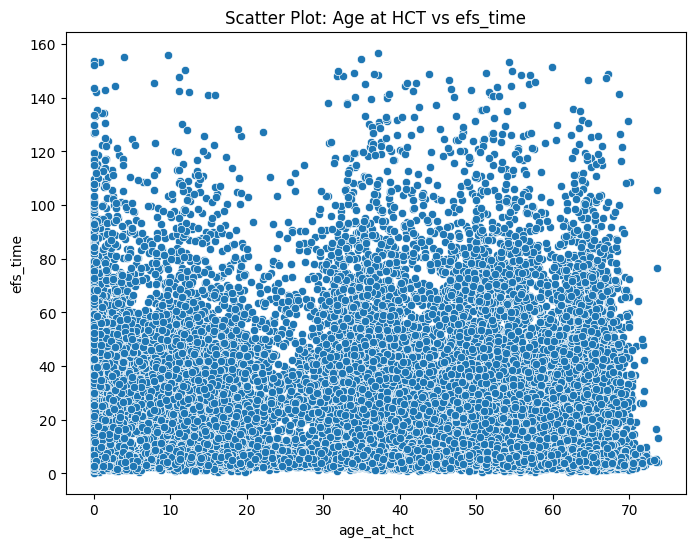

In [170]:
# 2.1 Scatter Plot between 'age_at_hct' and 'efs_time'
plt.figure(figsize=(8, 6))
sns.scatterplot(x='age_at_hct', y='efs_time', data=train_data)
plt.title("Scatter Plot: Age at HCT vs efs_time")
plt.show()


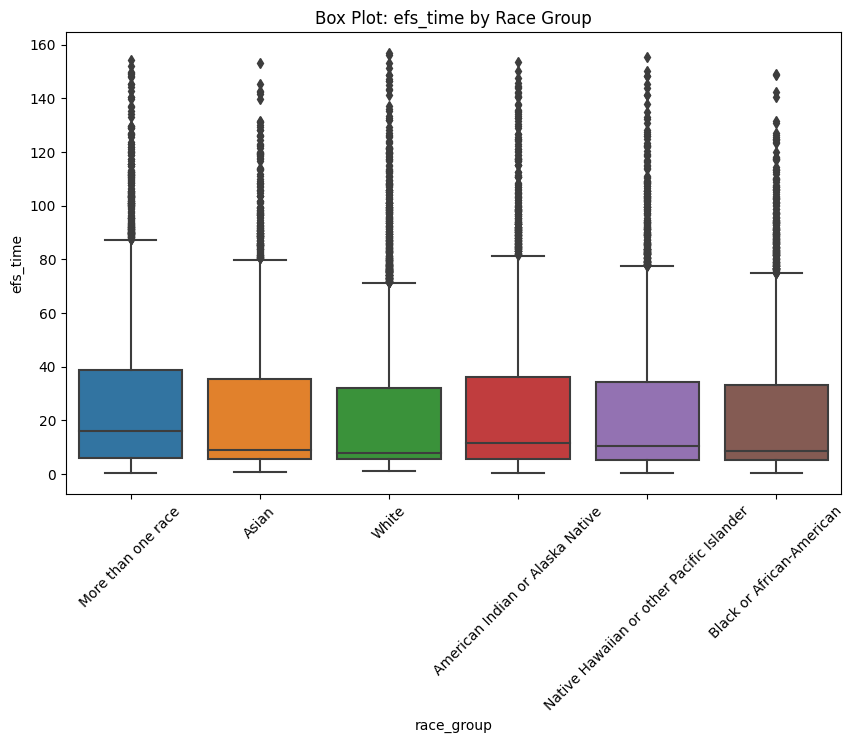

In [171]:
# 4.1 Box Plot of 'efs_time' by 'race_group'
plt.figure(figsize=(10, 6))
sns.boxplot(x='race_group', y='efs_time', data=train_data)
plt.title("Box Plot: efs_time by Race Group")
plt.xticks(rotation=45)
plt.show()

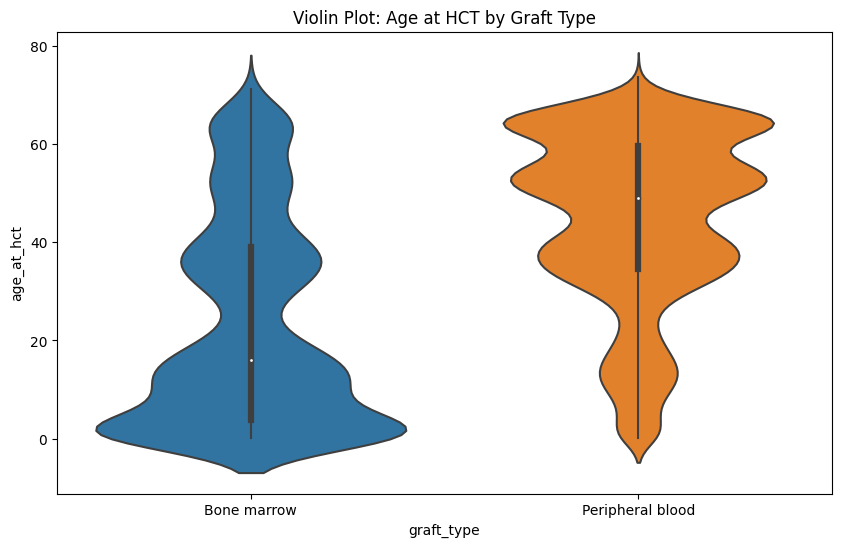

In [172]:
# 4.2 Violin Plot of 'age_at_hct' by 'graft_type'
plt.figure(figsize=(10, 6))
sns.violinplot(x='graft_type', y='age_at_hct', data=train_data)
plt.title("Violin Plot: Age at HCT by Graft Type")
plt.show()

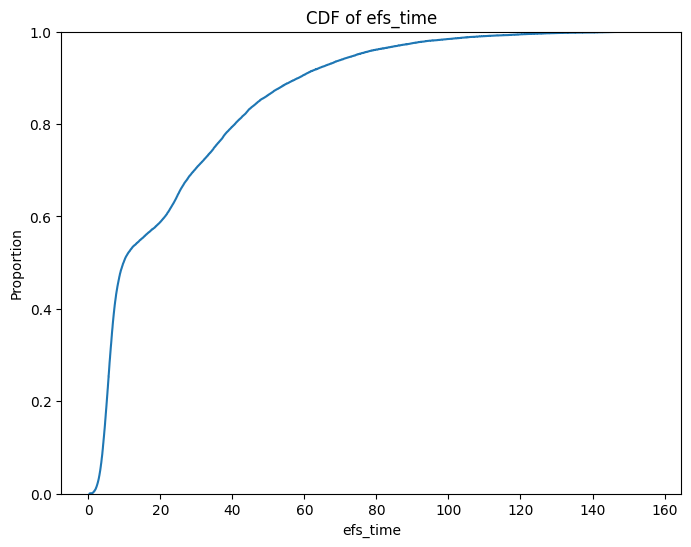

In [173]:
# 5. Cumulative Distribution Function (CDF) for 'efs_time'
plt.figure(figsize=(8, 6))
sns.ecdfplot(train_data['efs_time'])
plt.title("CDF of efs_time")
plt.show()

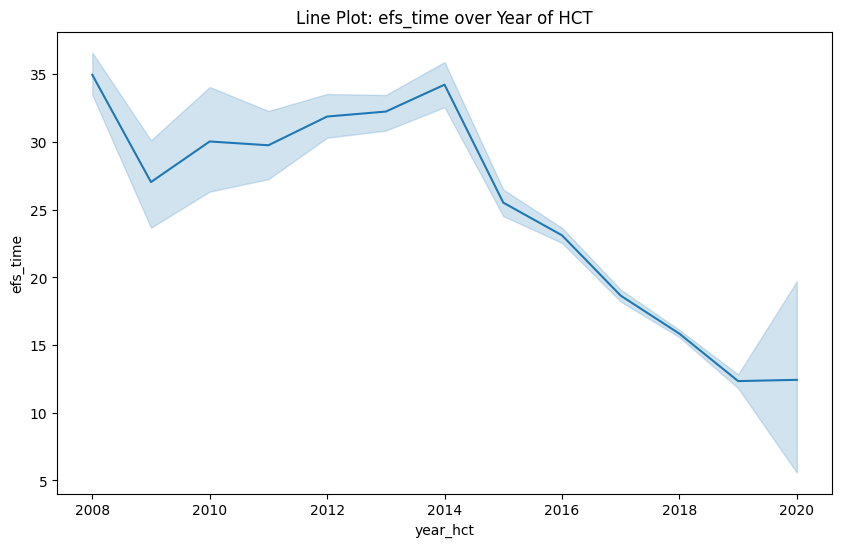

In [174]:
# 6.1 Line Plot of 'efs_time' over 'year_hct'
plt.figure(figsize=(10, 6))
sns.lineplot(x='year_hct', y='efs_time', data=train_data)
plt.title("Line Plot: efs_time over Year of HCT")
plt.show()

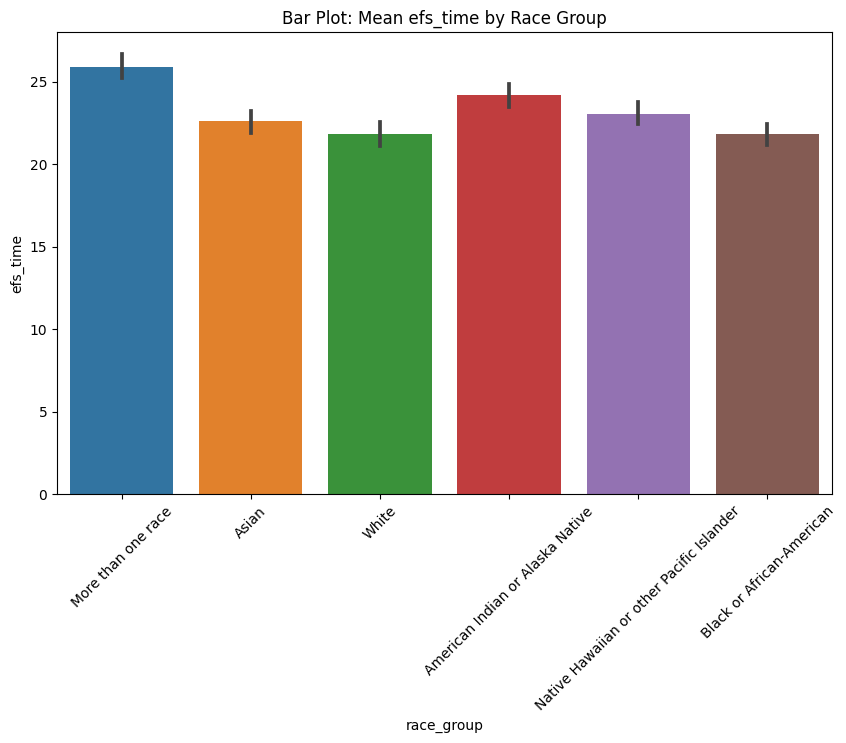

In [175]:
# 6.2 Bar Plot of Mean 'efs_time' by 'race_group'
plt.figure(figsize=(10, 6))
sns.barplot(x='race_group', y='efs_time', data=train_data, estimator=np.mean)
plt.title("Bar Plot: Mean efs_time by Race Group")
plt.xticks(rotation=45)
plt.show()

In [176]:
# 6.6 Interactive Violin Plot of 'age_at_hct' by 'graft_type'
fig = px.violin(train_data, x='graft_type', y='age_at_hct', title="Interactive Violin Plot: Age at HCT by Graft Type")
fig.show()


In [177]:
# 6.7 Interactive Histogram of 'efs_time' Distribution
fig = px.histogram(train_data, x='efs_time', nbins=30, title="Interactive Histogram: Distribution of efs_time")
fig.show()

In [178]:
# 6.8 Interactive KDE Plot of 'age_at_hct' Distribution
fig = px.density_contour(train_data, x='age_at_hct', title="Interactive KDE Plot: Age at HCT")
fig.show()

In [179]:
# 6.10 Interactive 3D Scatter Plot between 'age_at_hct', 'efs_time', and 'race_group'
fig = px.scatter_3d(train_data, x='age_at_hct', y='efs_time', z='comorbidity_score', color='race_group', title="Interactive 3D Scatter Plot")
fig.show()

In [180]:
# 10. Interactive Line Plot of 'efs_time' over 'year_hct'
fig = px.line(train_data, x='year_hct', y='efs_time', color='race_group', title="Interactive Line Plot: efs_time over Year of HCT")
fig.show()


In [181]:
# 11. Interactive Area Plot of 'efs_time' by 'race_group'
fig = px.area(train_data, x='year_hct', y='efs_time', color='race_group', title="Interactive Area Plot: efs_time by Race Group")
fig.show()

In [182]:
# 12. Interactive Sunburst Chart of 'race_group' and 'graft_type'
fig = px.sunburst(train_data, path=['race_group', 'graft_type'], title="Interactive Sunburst Chart: Race Group and Graft Type")
fig.show()

In [183]:
# 14. Interactive Treemap of 'race_group' and 'graft_type'
fig = px.treemap(train_data, path=['race_group', 'graft_type'], title="Interactive Treemap: Race Group and Graft Type")
fig.show()

In [184]:
fig = px.scatter_3d(train_data, x='age_at_hct', y='efs_time', z='comorbidity_score', color='race_group', title="Interactive 3D Scatter Plot")
fig.show()

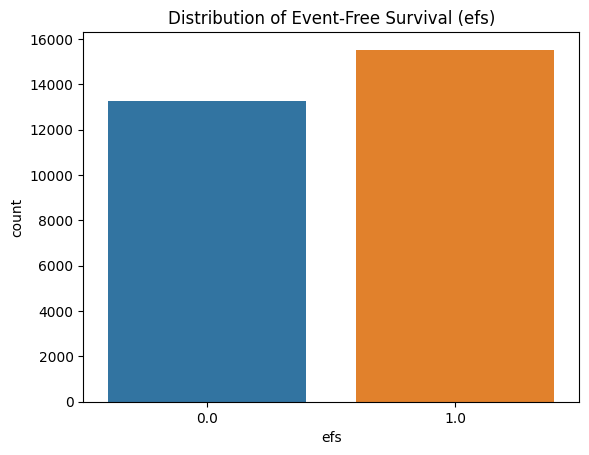

In [185]:
# Exploratory Data Analysis (EDA)
# Distribution of the target variable 'efs'
sns.countplot(x='efs', data=train_data)
plt.title("Distribution of Event-Free Survival (efs)")
plt.show()


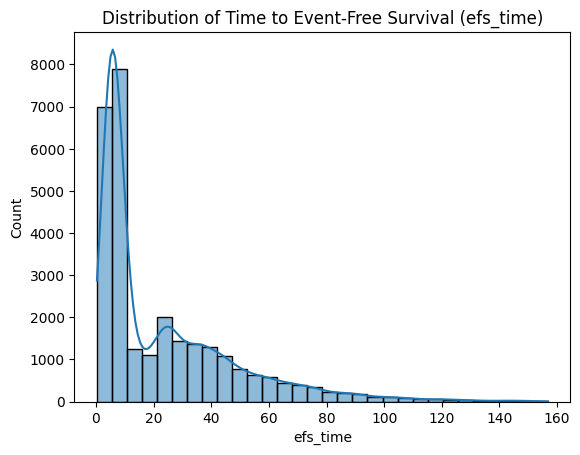

In [186]:
# Distribution of 'efs_time'
sns.histplot(train_data['efs_time'], bins=30, kde=True)
plt.title("Distribution of Time to Event-Free Survival (efs_time)")
plt.show()

In [187]:
# Preprocessing
# Separate features and target
X = train_data_processed.drop('efs', axis=1) 
y = train_data_processed['efs']

In [188]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [189]:
def clean_feature_names(df):
    df.columns = [col.replace('[', '_').replace(']', '_').replace('<', '').replace('>', '').replace('/', '_') for col in df.columns]
    return df

X_train = clean_feature_names(X_train)
X_val = clean_feature_names(X_val)

In [190]:
model_xgb = xgb.XGBRegressor(use_label_encoder=False, eval_metric='rmse')
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [191]:
y_pred_xgb = model_xgb.predict(X_val)
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_xgb)))
print("XGBoost R^2:", r2_score(y_val, y_pred_xgb))


XGBoost RMSE: 0.09974729031025353
XGBoost R^2: 0.9600148240636438


In [192]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)

RandomForestRegressor()

In [193]:
y_pred_rf = model_rf.predict(X_val)
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_rf)))
print("Random Forest R^2:", r2_score(y_val, y_pred_rf))

Random Forest RMSE: 0.09819782329563115
Random Forest R^2: 0.9612474290453584


In [194]:
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X_val)

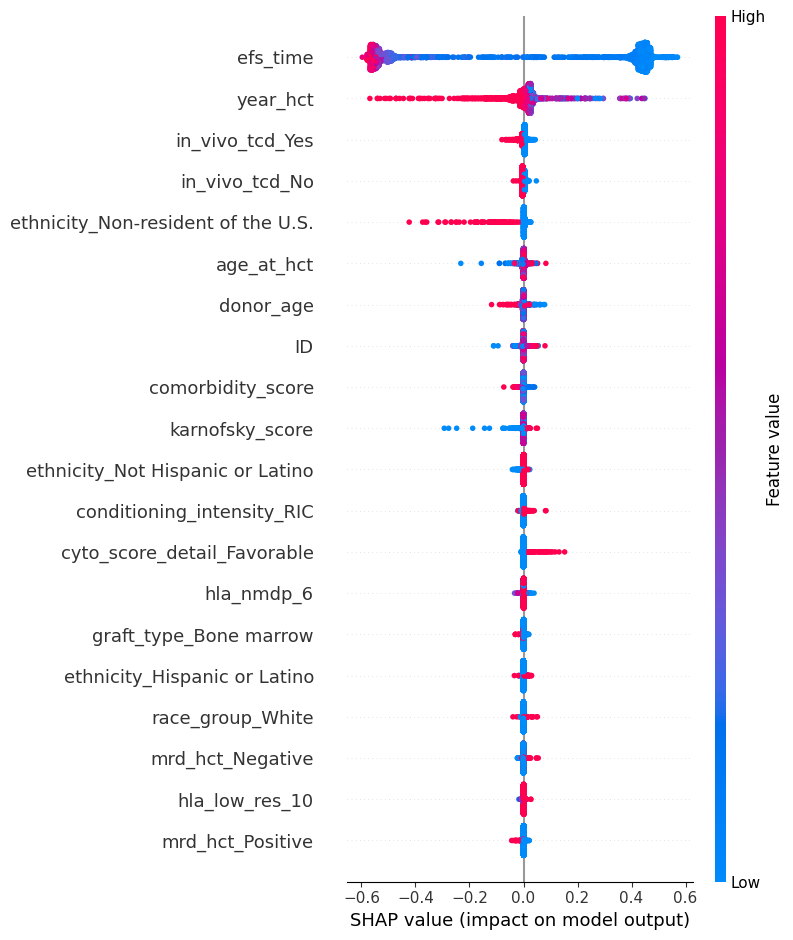

In [195]:
shap.summary_plot(shap_values, X_val)

In [196]:
explainer_lime = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, mode='regression')
i = 0  
exp = explainer_lime.explain_instance(X_val.values[i], model_xgb.predict)
exp.show_in_notebook()


In [197]:
test_data_processed = pd.get_dummies(test_data, drop_first=True)

In [198]:
missing_cols = set(X_train.columns) - set(test_data_processed.columns)
for col in missing_cols:
    test_data_processed[col] = 0

In [199]:
test_data_processed = test_data_processed[X_train.columns]

In [200]:
predictions = model_xgb.predict(test_data_processed)

In [201]:
results = pd.DataFrame({
    'ID': test_data['ID'],  
    'Prediction': predictions
})

In [202]:
results.to_csv('submission.csv', index=False)
print("Predictions saved to 'submission .csv'")

Predictions saved to 'submission .csv'


In [203]:
results

ID  Prediction
0  28800    0.974711
1  28801    0.971344
2  28802    0.638895